# 顔文字生成器（サンプル）
単純ニューラルネットワークだけのシンプル構成  
2次元の系列データに対して転置を行うことで系列を学習させる

In [ ]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=29d4e2eeac526c799f87b724efec02764a7aa6aac7c315e71d799ec4c7359c12
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

from sklearn.manifold import TSNE

## 前処理

### データ読み込み

In [ ]:
# 特殊文字
sp = {'pad': '<PAD>',
      # 'bos': '<BOS>',
      # 'eos': '<EOS>',
      'unk': '<UNK>'}
# pad : padding. 文字列長を一定にするために使う
# bos : begin of sequence. 文頭文字．Decoderの最初の入力
# eos : end of sequence. 文末文字．
# unk : unknown. 出現数が低いものに割り当てる

In [ ]:
sp.values()

dict_values(['<PAD>', '<UNK>'])

In [ ]:
KAOMOJI_MAX = 10    # 顔文字最大長

kmj_list = []   # 顔文字リスト
len_list = []       # <BOS> から <EOS> までの文字数のリスト
char_list = []      # 顔文字に使用されている文字のリスト

char_list += list(sp.values())
file_name = 'kaomoji_MAX=' + str(KAOMOJI_MAX) + '.txt'

with open(file_name, mode='r') as file:
  for line in file:
    # temp = [sp['bos']]
    temp = list(line.replace('\n', ''))
    # temp += [sp['eos']]
    len_list.append(len(temp))
    temp += [sp['pad'] for _ in range(KAOMOJI_MAX - len(temp))]
    kmj_list.append(temp)
    char_list += temp

# 重複を消す
char_list = sorted(set(char_list), key=char_list.index)

In [ ]:
print(kmj_list[0])

['(', '(', '(', '\u3000', '̄', 'ー', '\u3000', '̄', '\u3000', ')']


In [ ]:
print('Number of kaomoji  :', len(kmj_list))
print('Number of character:', len(char_list))

Number of kaomoji  : 5457
Number of character: 719


### 出現数が少ないものを置換

In [ ]:
# 最小出現数
MIN_APPEAR = 20

kmj_list = np.array(kmj_list)

cnt = 0
for c in char_list:
  mask = (kmj_list == c)
  if np.sum(mask) < MIN_APPEAR:
    kmj_list[mask] = sp['unk']

char_list = list(sp.values()) + kmj_list.flatten().tolist()
char_list = sorted(set(char_list), key=char_list.index)

In [ ]:
print('Number of character:', len(char_list))

Number of character: 137


### 添字検索
顔文字に使われる文字が文字リストの何番目にあるか調べる

In [ ]:
kmj_index = []    # 添字リスト

for kmj in kmj_list.tolist():
  temp = [char_list.index(c) for c in kmj]
  kmj_index.append(temp)

In [ ]:
print(len_list[0])
kmj_index[0]

10


[2, 2, 2, 3, 4, 5, 3, 4, 3, 6]

### One-hotベクトル化



In [ ]:
kmj_num = len(kmj_index)        # 顔文字の総数
kmj_size = len(kmj_index[0])    # 1つの顔文字の長さ
char_num = len(char_list)       # 文字の種類数

# One-hotベクトルリスト
kmj_onehot = np.zeros((kmj_num, kmj_size, char_num))

for i, index in enumerate(kmj_index):
  mask = range(char_num) == np.array(index).reshape((kmj_size, 1))
  kmj_onehot[i][mask] = 1

In [ ]:
kmj_onehot.shape

(5457, 10, 137)

### 訓練・検証・テスト用に分ける

In [ ]:
dataset = torch.utils.data.TensorDataset(
  torch.tensor(kmj_onehot.astype('float32')),
  torch.tensor(len_list)
)

In [ ]:
train_size = int(len(dataset) * 0.85)
valid_size = int(len(dataset) * 0.10)
test_size  = len(dataset) - train_size - valid_size

# indices = np.arange(len(dataset))

# dataset_train = torch.utils.data.Subset(dataset, indices[:train_size])
# dataset_valid = torch.utils.data.Subset(dataset, indices[train_size:train_size+valid_size])
# dataset_test  = torch.utils.data.Subset(dataset, indices[train_size+valid_size:])

split = [train_size, valid_size, test_size]

dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, split)

In [ ]:
train_size

4638

In [ ]:
dataset_train[0]

(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(7))

In [ ]:
batch_size = 32

dataloader_train = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
  dataset_valid,
  batch_size=batch_size,
  shuffle=True
)

In [ ]:
for x, len_seq in dataloader_train:
  print(x.shape, len_seq.shape)
  break

torch.Size([32, 10, 137]) torch.Size([32])


## モデル

### Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, N, char_num, emb_dim):
    super().__init__()
    self.emb = nn.Linear(char_num, emb_dim)
    self.linear = nn.Linear(N, N)

  def forward(self, x):
    x = self.emb(x)
    # x = F.sigmoid(x)
    x = torch.transpose(x, -2, -1)
    x = self.linear(x)
    # x = F.sigmoid(x)
    x = torch.transpose(x, -2, -1)
    return x

In [ ]:
encoder = Encoder(10, 137, 8)
x = torch.rand(32, 10, 137)
encoder(x).shape

torch.Size([32, 10, 8])

### Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, N, char_num, emb_dim):
    super().__init__()
    self.linear1 = nn.Linear(N, N)
    self.linear2 = nn.Linear(emb_dim, char_num)

  def forward(self, x):
    x = torch.transpose(x, -2, -1)
    x = self.linear1(x)
    # x = F.relu(x)
    x = torch.transpose(x, -2, -1)
    x = self.linear2(x)
    return x

In [ ]:
decoder = Decoder(10, 137, 8)
x = torch.rand(32, 10, 8)
decoder(x).shape

torch.Size([32, 10, 137])

### Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, N, char_num, emb_dim):
    super().__init__()
    self.encoder = Encoder(N, char_num, emb_dim)
    self.decoder = Decoder(N, char_num, emb_dim)

  def forward(self, x):
    z = self.encoder(x)
    y = self.decoder(z)
    return y

In [ ]:
generator = Generator(10, 137, 8)
x = torch.rand(32, 10, 137)
generator(x).shape

torch.Size([32, 10, 137])

## 学習

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
n_epochs = 10

N = KAOMOJI_MAX
char_num = len(char_list)
emb_dim = 8

net = Generator(N, char_num, emb_dim)

optimizer = optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(n_epochs):
  losses_train = []
  losses_valid = []

  # 訓練
  net.train()
  for x, len_seq in dataloader_train:
    net.zero_grad()  # 勾配の初期化

    #x.to(device)
    #t.to(device)

    y = net(x)

    loss = criterion(y, x)
    loss.backward()  # 誤差の逆伝播
    losses_train.append(loss.tolist())

    optimizer.step()  # パラメータの更新

  # 検証
  net.eval()
  for x, len_seq in dataloader_valid:
    y = net(x)

    loss = criterion(y, x)
    losses_valid.append(loss.tolist())

  if (epoch+1) % 1 == 0:
    print('EPOCH: {:>2}, Train Loss: {:>4.5f}, Valid Loss: {:>4.5f}'.format(
        epoch+1,
        np.mean(losses_train),
        np.mean(losses_valid),
    ))

EPOCH:  1, Train Loss: 0.08751, Valid Loss: 0.03946
EPOCH:  2, Train Loss: 0.03444, Valid Loss: 0.03453
EPOCH:  3, Train Loss: 0.03314, Valid Loss: 0.03303
EPOCH:  4, Train Loss: 0.03305, Valid Loss: 0.03352
EPOCH:  5, Train Loss: 0.03302, Valid Loss: 0.03370
EPOCH:  6, Train Loss: 0.03301, Valid Loss: 0.03369
EPOCH:  7, Train Loss: 0.03300, Valid Loss: 0.03294
EPOCH:  8, Train Loss: 0.03303, Valid Loss: 0.03302
EPOCH:  9, Train Loss: 0.03306, Valid Loss: 0.03610
EPOCH: 10, Train Loss: 0.03312, Valid Loss: 0.03351


## 評価

In [ ]:
def convert_str(x):
  x = np.array(char_list)[x.argmax(dim=1)]
  x = [c for c in x if c not in sp.values()]

  return ''.join(x)

def generate(net, base=None, rate=3.0):
  if base is None:
    z = 2*rate * torch.rand(1, N, emb_dim) - rate
  else:
    z = net.encoder(base.unsqueeze(0))
    eps = 2*rate * torch.rand(1, N, emb_dim) - rate
    z = z + eps

  y = net.decoder(z)
  gen = convert_str(y.squeeze(0))

  return ''.join(gen)

### 次元圧縮テスト
目標はbaseとgenerateで全く同じもの．
次元圧縮して，潜在ベクトルが獲得できているかどうかのテスト．

In [ ]:
for i in np.random.randint(0, len(dataset_test), size=10):
  test = dataset_test[i][0]
  print('base     :', convert_str(test))
  print('generate :', generate(net, base=test, rate=0.0))

base     : (　̄-(　̄)
generate : (　̄-(　̄)
base     : (　́ー`)
generate : (　́ー`)
base     : (*　́-`)
generate : (*　́-`)
base     : o(*^^*)o
generate : o(*××*)o
base     : (*　́∇`*;△
generate : (*　́∇`*;△
base     : (●>∀<*)ノシ
generate : (●>∀<*)ノ゚
base     : (　̄●●　̄;)
generate : (　̄●●　̄;)
base     : ―(T_T)!!!
generate : Д(●_●)q!!!
base     : o(*^^*)o
generate : o(*××*)o
base     : o(≧∪≦)☆
generate : o(≧′≦)☆


### 生成テスト
潜在ベクトルに乱数を入力しその出力を見る．

In [ ]:
for _ in range(10):
  print('generate :', generate(net, base=None, rate=0.5))

generate : dヽ0>ωゝ~)!
generate : \̄ヘ♪:]∀`!ω
generate : ́ロぉ́ーヘ>?ヘ
generate : ⊂\△≦ノぉヘメ"ヘ
generate : ゝ゚(́・≦ー{!x
generate : ]ノ∀シ"|Θノ,о
generate : 0人:ヘ`*⌒⊃
generate : ω∀ー`●[д)≦"
generate : x\_ε._∀`"
generate : ”̄Aε`A_◇0


### 類似度テスト
訓練データの中から潜在ベクトルの距離が近いものを見る．

In [ ]:
def similar(net, base, num=10):
  z = net.encoder(base.unsqueeze(0))

  size = list(z.shape)
  size[0] = 0
  z_list = torch.empty(size, dtype=torch.float)
  z_list = net.encoder(dataset_train[:][0])

  diff = z_list - z
  norm = enumerate(torch.norm(diff.reshape(-1, N*emb_dim), dim=1))
  norm = sorted(norm, key=lambda x: x[1])

  for i in range(num):
    min_index = norm[i][0]
    str = convert_str(dataset_train[min_index][0])
    print('{} : {}'.format(str, norm[i][1]))

In [ ]:
i = np.random.randint(0, len(dataset_test))
test = dataset_test[i][0]
print(convert_str(test), ' : base')
similar(net, test, num=10)

☆\(　^　^)/!  : base
☆\(　^　^)/ : 3.012641191482544
|\(　'ω')/| : 4.420314311981201
☆ヽ(　́▽`)/☆ : 4.621111869812012
~\(_　_;)/~ : 5.449403285980225
||(OдO`)|| : 5.538583755493164
~o(　̄　̄*)♪ : 5.650570869445801
☆⌒Σ(≧д≦)ゝ! : 5.838888168334961
!(*　̄　̄)/ : 6.040688991546631
ψ(*`^　́)ψ : 6.13253927230835
☆^(*≧ω≦)ノ♪ : 6.163021087646484


### 潜在ベクトルの分布図
t-SNEという次元削減アルゴリズムがあるらしいので，それを使って潜在ベクトルを2次元化して表示

In [ ]:
z_list = net.encoder(dataset_train[:][0]).reshape(-1, N*emb_dim).detach().numpy()
z_reduc = TSNE(n_components=2).fit_transform(z_list).T

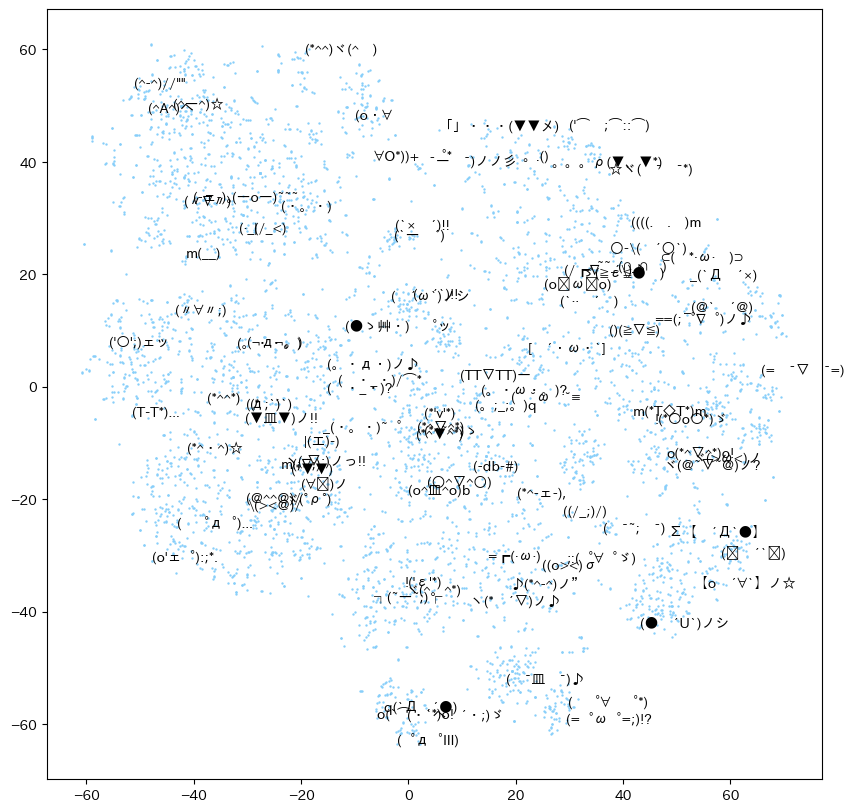

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(*z_reduc, s=0.5, c='lightskyblue')

for i in random.sample(range(len(dataset_train)), 100):
  plt.text(*z_reduc[:, i], convert_str(dataset_train[i][0]), fontsize=10)

plt.show()

## 感想

このネットワークは，  
Encoder：Embedding+Linear+Transpose+Linear  
Decoder：Linear+Transpose+Linear  
の構成

転置を繰り返し、文字ベクトル方向と系列方向の両方で学習させる．

性能としては，入力と出力を同じにすることはできるが，ランダム生成はできない．  

似ているものを出力させるときには，潜在ベクトル(今回は行列)に少しノイズを足して計算させている．
このとき，'( )'は変化しにくい気がする．